# GMAC Analysis and Optimization Notebook
This notebook contains the entire code for the analysis and optimization of the 
GMAC alorithm using the data collected from a previous study by Dr. Ann David [1].




### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import signal
import pathlib

### Custom Modules

In [3]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

## Define notebook level constants

In [131]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)
deltaT = np.timedelta64(int(dT * 1e9), 'ns')

## Read the Controls and Patients Data

In [14]:
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

### Comparing pitch angle from th IMU and just the accelerometer

In [146]:
subj = 1
# Pitch values estimated from the IMU data.
left_pitch = left[left.subject==1].pitch.values
right_pitch = right[right.subject==1].pitch.values

# Estimation pitch from the accelerometer data.
left_pitch_hat = misc.compute_tilt(left[left.subject==subj].ax, Fs + 1)
right_pitch_hat = misc.compute_tilt(right[right.subject==subj].ax, Fs + 1)

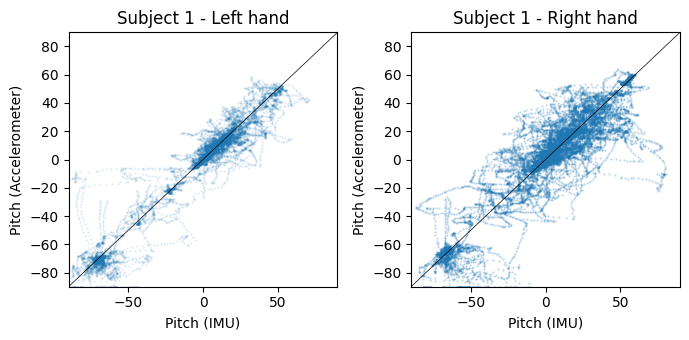

In [165]:
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(121)
ax.plot([-90, 90], [-90, 90], lw=0.5, color="k")
ax.scatter(left_pitch, left_pitch_hat, s=2, marker='.', alpha=0.1)
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.set_xlabel("Pitch (IMU)")
ax.set_ylabel("Pitch (Accelerometer)")
ax.set_title(f"Subject {subj} - Left hand")
ax = fig.add_subplot(122)
ax.plot([-90, 90], [-90, 90], lw=0.5, color="k")
ax.scatter(right_pitch, right_pitch_hat, s=1, marker='.', alpha=0.3)
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.set_xlabel("Pitch (IMU)")
ax.set_ylabel("Pitch (Accelerometer)")
ax.set_title(f"Subject {subj} - Right hand")
plt.tight_layout()

### Comparing pitch angle from th IMU and just the accelerometer

In [167]:
subj = 1
# act_counts = (ca.compute_vector_magnitude(r[r.subject==1])).counts.values
ca.compute_vector_magnitude(left[left.subject==1])

TypeError: Could not convert 2020-03-11 16:21:19.820 to numeric

In [ ]:
b, a = signal.butter(2, 1/(2*50), 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt)<0.068] = 0
ay_filt[np.abs(ay_filt)<0.068] = 0
az_filt[np.abs(az_filt)<0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i+50]) for i in range(0, len(amag), 50)]
w = 5
amag = np.append(np.ones(w-1)*amag[0], amag)

# moving average filter
amag = np.convolve(amag, np.ones(w), 'valid') / w

In [90]:
# Get segmented data for the two arms for controls and patients
left_segdata = misc.get_segmented_data(left, deltaT)
right_segdata = misc.get_segmented_data(right, deltaT)
aff_segdata = misc.get_segmented_data(aff, deltaT)
unaff_segdata = misc.get_segmented_data(unaff, deltaT)

Text(0.5, 1.0, 'Subject 7 - Right Arm')

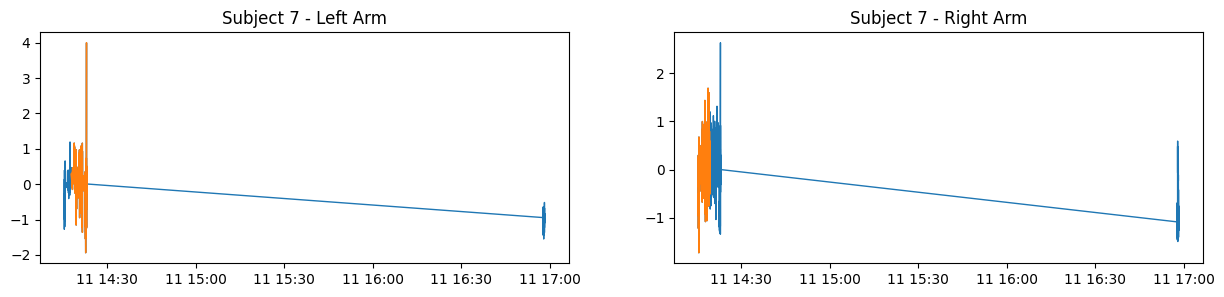

In [126]:
# Generate plots to verify that the data is segmented correctly
subj = 7
fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(121)
ax.plot(left[left.subject == subj].index,
        left[left.subject == subj].ax,
        lw=1, label='Left Original')
ax.plot(left_segdata[subj].index,
        left_segdata[subj].ax,
        lw=1, label='Left Segmented')
ax.set_title(f"Subject {subj} - Left Arm")
ax = fig.add_subplot(122)
ax.plot(right[right.subject == subj].index,
        right[right.subject == subj].ax,
        lw=1, label='Right Original')
ax.plot(right_segdata[subj].index,
        right_segdata[subj].ax,
        lw=1, label='Right Segmented')
ax.set_title(f"Subject {subj} - Right Arm")

In [120]:
len(left[left.subject==10])

22317

In [122]:
np.diff(left[left.subject==10].index)[5325:5335]

array([   20000000,    20000000,    20000000,    20000000,    20000000,
          20000000,    20000000, 21020000000,    20000000,    20000000],
      dtype='timedelta64[ns]')

In [123]:
21 * 50

1050

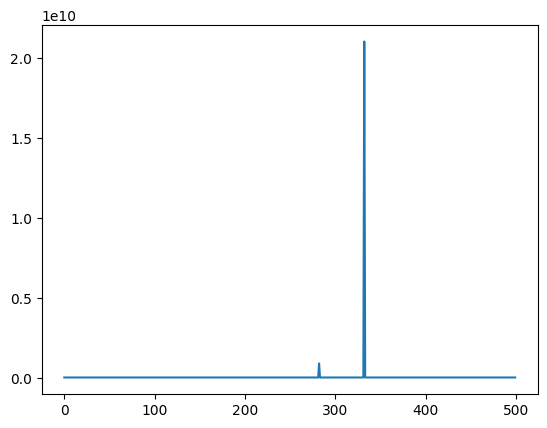

In [121]:
plt.plot(np.diff(left[left.subject==10].index)[5000:5500])


In [116]:
np.diff(left[left.subject==10].index)

array([20000000, 20000000, 20000000, ..., 20000000, 20000000, 20000000],
      dtype='timedelta64[ns]')

In [113]:
5 * deltaT

numpy.timedelta64(100000000,'ns')

In [112]:
misc.get_largest_continuous_segment_indices(left, 10, deltaT)

(5332, 20212)

In [34]:
_inx = np.diff(right[right.subject == 10].index)
np.where(_inx != _inx[0])

(array([ 9394,  9444, 13314, 21004]),)

In [31]:
right.subject.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10,  1])

# Pitch

In [15]:
def compute_tilt(accl_farm: np.array, nwin: int) -> np.array:
    # Moving averaging using the Savitzky-Golay filter
    af = signal.savgol_filter(accl_farm, window_length=nwin, polyorder=0,
                              mode='costant')
    af[af < -1] = -1
    af[af > 1] = 1
    return -np.rad2deg(np.arccos(af)) + 90

In [35]:
ax = r[r.subject==1].ax.values
pitch_hat = compute_tilt(ax, 50)
pitch = r[r.subject==1].pitch.values

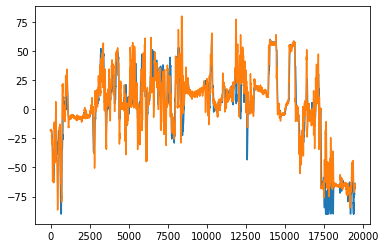

In [11]:
plt.plot(pitch_hat)
plt.plot(pitch)

Text(0, 0.5, 'pitch')

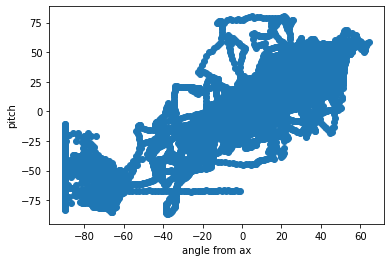

In [12]:
plt.scatter(pitch_hat, pitch)
plt.xlabel('angle from ax')
plt.ylabel('pitch')

In [13]:
pearsonr(pitch, pitch_hat)

(0.9046985706407787, 0.0)

# Activity counts

In [16]:
counts = (ca.compute_vector_magnitude(r[r.subject==1])).counts.values
ay = r[r.subject==1].ay
az = r[r.subject==1].az

In [17]:
b, a = signal.butter(2, 1/(2*50), 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt)<0.068] = 0
ay_filt[np.abs(ay_filt)<0.068] = 0
az_filt[np.abs(az_filt)<0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i+50]) for i in range(0, len(amag), 50)]
w = 5
amag = np.append(np.ones(w-1)*amag[0], amag)

# moving average filter
amag = np.convolve(amag, np.ones(w), 'valid') / w

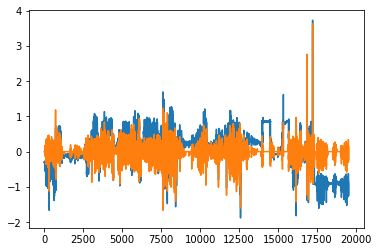

In [18]:
plt.plot(ax)
plt.plot(ax_filt)

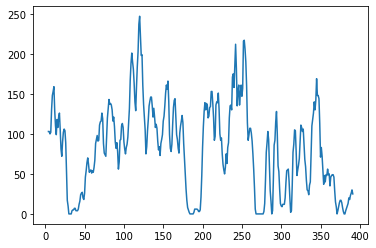

In [19]:
plt.plot(counts)

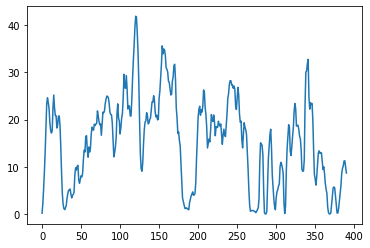

In [20]:
plt.plot(amag)

In [ ]:
counts[np.isnan(counts)] = 0

Text(0, 0.5, 'counts')

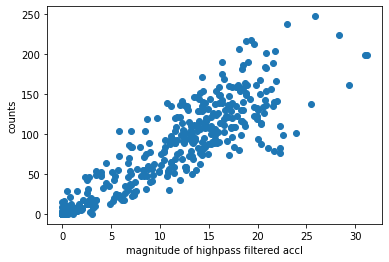

In [ ]:
plt.scatter(amag, counts[1:])
plt.xlabel('magnitude of highpass filtered accl')
plt.ylabel('counts')

In [ ]:
pearsonr(amag, counts[1:])

(0.8822045564601536, 2.618118077333752e-129)

# GMAC

In [36]:
gmac = [1 if np.abs(pitch) < 30 and count > 0 else 0 for pitch, count in zip(pitch_hat[0:len(pitch_hat):50], amag)]
gnd = [r[r.subject==1].gnd[i] for i in range(0, len(r[r.subject==1]), 50)]

In [41]:
ca.confmatrix(gmac, gnd)

,true positive,false positive,false negative,true negative,accuracy,gwets ac1 score,sensitivity,specificity,precision,f1 score,balanced accuracy
0,0.58312,0.120205,0.16624,0.130435,0.713555,0.524543,0.778157,0.520408,0.829091,0.802817,0.649283


In [33]:
gmac_original = (ca.get_gm_modified(r[r.subject==1])).pred.values

In [42]:
ca.confmatrix(gmac_original, gnd[1:])

,true positive,false positive,false negative,true negative,accuracy,gwets ac1 score,sensitivity,specificity,precision,f1 score,balanced accuracy
0,0.54359,0.110256,0.207692,0.138462,0.682051,0.453757,0.723549,0.556701,0.831373,0.773723,0.640125


# optimizing parameters 

In [ ]:
def compute_gmac(ax, ay, az, freq=50, pitch_threshold=30, counts_threshold=0, hpf_cutoff=1, pitch_window=1, counts_window=5):
  w = pitch_window*round(freq)
  ax = np.append(np.ones(w-1)*ax[0], ax)

  # moving average filter
  ax = np.convolve(ax, np.ones(w), 'valid') / w

  ax[ax<-1] = -1
  ax[ax>1] = 1
  pitch = -np.rad2deg(np.arccos(ax))+90

  b, a = signal.butter(2, hpf_cutoff/(2*freq), 'high')
  ax_filt = signal.filtfilt(b, a, ax)
  ay_filt = signal.filtfilt(b, a, ay)
  az_filt = signal.filtfilt(b, a, az)

  deadband_threshold = 0.068
  ax_filt[np.abs(ax_filt)<deadband_threshold] = 0
  ay_filt[np.abs(ay_filt)<deadband_threshold] = 0
  az_filt[np.abs(az_filt)<deadband_threshold] = 0

  amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
  amag = [sum(amag[i:i+freq]) for i in range(0, len(amag), freq)]
  w = counts_window
  amag = np.append(np.ones(w-1)*amag[0], amag)

  # moving average filter
  amag = np.convolve(amag, np.ones(w), 'valid') / w

  gmac = [1 if np.abs(pitch) < pitch_threshold and count > counts_threshold else 0 for pitch, count in zip(pitch_hat[0:len(pitch_hat):freq], amag)]
  return gmac